In [56]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
%matplotlib inline

import popsims
from popsims.simulator import Population, pop_mags, compute_vols_and_numbers, simulate_population
from popsims.galaxy import Disk, Halo
from popsims.tools import sample_from_powerlaw
from popsims.plot_style import  plot_style
#plt.style.use('fivethirtyeight')
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning) 

plot_style()

plt.style.use('dark_background')

In [2]:
#roman deep field in the Fornax constellation
#https://hubblesite.org/contents/media/images/2021/003/01EX00FCXRZ7YVP4MPMAT1PW2X?news=true
#l=-27° 47' 29.04"
#03h 32m 38.99s
l= 2*np.pi*np.random.uniform(0, 1, 100)*u.radian
b= (np.arccos(2*np.random.uniform(0, 1, 100)-1)-np.pi/2)*u.radian

#coords=SkyCoord([SkyCoord(l="-27° 47' 29.04", b='03h 32m 38.99s', frame='galactic' ),
#          SkyCoord(l="-45° 47' 29.04", b='00h 32m 38.99s', frame='galactic' )]).transform_to(ICRS)

coords=SkyCoord(l=l, b=b, frame='galactic' ).transform_to(ICRS)

In [3]:
def simulate_full_pop(imf_power, dmin, dmax, roman_keys, nsample=1e6):
    df_thin=simulate_population(disk, coords, dmin, dmax, nsample=nsample, poptype='dwarfs', galtype='thin_disk', age_range=[0.01, 8], \
                        mass_range=[0.01, 0.1], mag_keys=roman_keys, evolmodel='burrows1997', popargs={'imf_power': imf_power},
                        get_from='spt', dsteps=10_000)
    
    df_thick=simulate_population(disk, coords, dmin, dmax, nsample=nsample, poptype='dwarfs', galtype='thick_disk', age_range=[8, 14], \
                        mass_range=[0.01, 0.1], mag_keys=roman_keys, evolmodel='burrows1997', popargs={'imf_power': imf_power},
                        get_from='spt', dsteps=10_000)
    
    df_halo=simulate_population(disk, coords, dmin, dmax, nsample=nsample, poptype='dwarfs', galtype='halo', age_range=[10, 14], \
                        mass_range=[0.01, 0.1], mag_keys=roman_keys, evolmodel='burrows1997',popargs={'imf_power': imf_power},
                        get_from='spt', dsteps=10_000)
    
    df_thin['population']='thin disk'
    df_thick['population']='thick disk'
    df_halo['population']='halo'
    #combine 
    df_final=pd.concat([df_thin.sample(int(nsample), replace=True),
                        df_thick.sample(int(0.12*nsample), replace=True),
                        df_halo.sample(int(0.0025*nsample), replace=True)]).reset_index(drop=True)
                        
    
    return df_final

In [4]:
#compute magnitudes from distances
#assign roman magnitudes
roman_keys=['WFI_R062', 'WFI_Z087', 'WFI_Y106', 'WFI_J129', 'WFI_H158', 'WFI_F184', 'WFI_Prism', 'WFI_Grism']
jwst_keys=['NIRISS_F090W', 'NIRISS_F115W', 'NIRISS_F150W', 'NIRISS_F200W']
euclid_keys=['EUCLID_Y', 'EUCLID_J', 'EUCLID_H']

all_keys=np.concatenate([roman_keys, jwst_keys, euclid_keys])

In [5]:
#draw masses from a power-law IMF and uniform ages
#define a galaxy density model and draw distances in a given direction
disk= Disk(H=300, L=2600)
tdisk=Disk(H=900, L=3600)
halo= Halo()

df0=simulate_full_pop(-1, 10,50_000, all_keys, nsample=1e6)
df1=simulate_full_pop(-0.5, 10,50_000, all_keys, nsample=1e6)
df2=simulate_full_pop(0, 10,50_000, all_keys, nsample=1e6)

100%|█████████████████████████████████████████| 100/100 [06:29<00:00,  3.90s/it]


/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/astropy/coordinates/baseframe.py:1210: AstropyDeprecationWarning: Transforming a frame instance to a frame class (as opposed to another frame instance) will not be supported in the future.  Either explicitly instantiate the target frame, or first convert the source frame instance to a `astropy.coordinates.SkyCoord` and use its `transform_to()` method.
  warnings.warn("Transforming a frame instance to a frame class (as opposed to another "



100%|█████████████████████████████████████████| 100/100 [06:28<00:00,  3.89s/it]


In [15]:
sptgrid=np.arange(15, 40)
maglimits_roman={'WFI_J129': [10, 26.2]}
maglimits_jwst={'NIRISS_F115W': [10, 27]}
maglimits_euclid={'NIRISS_F115W': [10, 27]}
maglimits_lss={''}

In [18]:
def compute_numbers(df0, cuts):
    query=''
    for k in cuts.keys():
        query += k+'<='+str(cuts[k][1])
    
    print (query)
    df= df0.query(query).reset_index(drop=True)
    ns= compute_vols_and_numbers(df, disk, tdisk, halo, sptgrid,coords, cuts)
    return ns

In [20]:
ns_roman0= compute_numbers(df0, maglimits_roman)
ns_roman1=compute_numbers(df1, maglimits_roman)
ns_roman2=compute_numbers(df2, maglimits_roman)

WFI_J129<=26.2


100%|███████████████████████████████████████████| 25/25 [00:10<00:00,  2.28it/s]


WFI_J129<=26.2


100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.12it/s]


WFI_J129<=26.2


100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.13it/s]


In [21]:
ns_jwst0= compute_numbers(df0, maglimits_jwst)
ns_jwst1=compute_numbers(df1, maglimits_jwst)
ns_jwst2=compute_numbers(df2, maglimits_jwst)

NIRISS_F115W<=27


100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.19it/s]


NIRISS_F115W<=27


100%|███████████████████████████████████████████| 25/25 [00:12<00:00,  2.03it/s]


NIRISS_F115W<=27


100%|███████████████████████████████████████████| 25/25 [00:13<00:00,  1.88it/s]


In [22]:
ns_euc0= compute_numbers(df0, maglimits_euclid)
ns_euc1=compute_numbers(df1, maglimits_euclid)
ns_euc2=compute_numbers(df2, maglimits_euclid)

NIRISS_F115W<=27


100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.19it/s]


NIRISS_F115W<=27


100%|███████████████████████████████████████████| 25/25 [00:12<00:00,  2.01it/s]


NIRISS_F115W<=27


100%|███████████████████████████████████████████| 25/25 [00:12<00:00,  1.93it/s]


In [83]:
AREA_JWST=124*(4*(u.arcmin**2)).to(u.radian**2)
AREA_ROMAN=(2_000*(u.degree**2)).to(u.radian**2)

<Quantity 0.13777778 deg2>

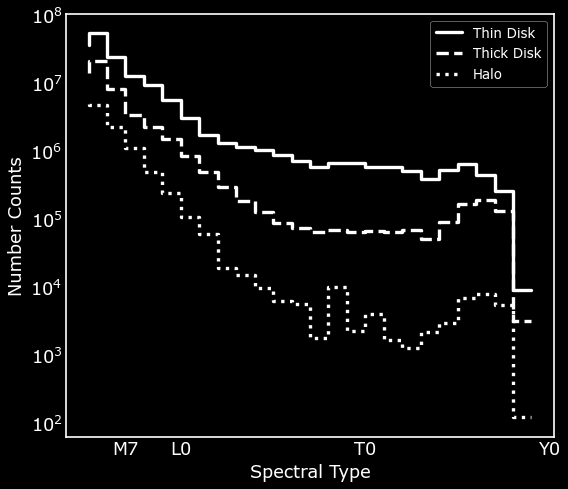

In [60]:
fig, ax=plt.subplots(figsize=(7, 7),sharey=True)

ax.step(ns_roman1[0].index, ns_roman1[0].thin*ns_roman1[1].thin*AREA_ROMAN,\
        color='#FFFFFF',  linestyle='-', label='Thin Disk', linewidth=3)

ax.step(ns_roman1[0].index, 0.12*ns_roman1[0].thick*ns_roman1[1].thick*AREA_ROMAN,\
         color='#FFFFFF',  linestyle='dashed', label='Thick Disk',  linewidth=3)

ax.step(ns_roman1[0].index, (1/400)*ns_roman1[0].halo*ns_roman1[1].halo*AREA_ROMAN,\
           color='#FFFFFF', linestyle='dotted', label='Halo',  linewidth=3)

ax.set(yscale='log', ylabel=r'Number Counts', xlabel='Spectral Type', \
       xticks=[17, 20, 30, 40], xticklabels=['M7', 'L0', 'T0', 'Y0'])

ax.minorticks_on()

ax.legend(fontsize=12)

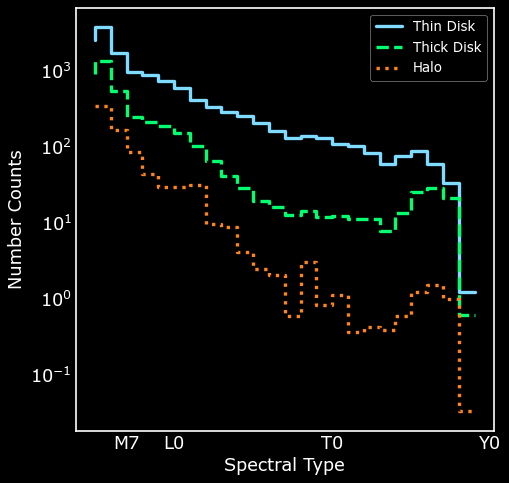

In [84]:
fig, ax=plt.subplots(figsize=(6, 7),sharey=True)

ax.step(ns_jwst1[0].index, ns_jwst1[0].thin*ns_roman1[1].thin*AREA_JWST,\
        color='#7FDBFF',  linestyle='-', label='Thin Disk', linewidth=3)

ax.step(ns_jwst1[0].index, 0.12*ns_jwst1[0].thick*ns_jwst1[1].thick*AREA_JWST,\
         color='#01FF70',  linestyle='dashed', label='Thick Disk',  linewidth=3)

ax.step(ns_jwst1[0].index, (1/400)*ns_jwst1[0].halo*ns_jwst1[1].halo*AREA_JWST,\
           color='#FF851B', linestyle='dotted', label='Halo',  linewidth=3)

ax.set(yscale='log', ylabel=r'Number Counts', xlabel='Spectral Type', \
       xticks=[17, 20, 30, 40], xticklabels=['M7', 'L0', 'T0', 'Y0'])

ax.minorticks_on()

ax.legend(fontsize=12)
plt.savefig('/users/caganze/jwst_preds.pdf')

In [86]:
np.nansum(ns_jwst1[0].halo*ns_roman1[1].halo*AREA_JWST.value)/400

1221.9572934901257

In [76]:
ns_jwst1[0].halo*ns_roman1[1].halo*AREA_JWST.value

15    1559.453652
16    1517.504581
17     739.125016
18     378.540238
19     184.655784
20     124.376319
21     114.778626
22     111.907580
23      42.790905
24      32.354041
25      18.563183
26      10.915552
27       9.129257
28       2.616158
29      13.405404
30       2.767309
31       4.342429
32       1.606650
33       1.120881
34       1.725634
35       2.166369
36       4.858526
37       5.366596
38       3.674931
39       0.083556
Name: halo, dtype: float64

In [74]:
0.149*124*4

73.904

In [88]:
124*(4*(u.arcmin**2))

<Quantity 496. arcmin2>

In [ ]:
0.14